In [1]:
import random as r

from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from AbstractArchitecture import AbstractArchitecture
from DenseEncoder import DenseEncoder
from DenseDecoder import DenseDecoder
from NormalizedMeanSquaredError import NormalizedMeanSquaredError as NMSE
from plot_model_prediction import plot_model_prediction

In [2]:
# Set Experiment Specifics
expt_name = "Experiment_01"
data_file_prefix = './data/NLSL_expt1'  ## FILL IN HERE (from file name)

# Network architecture design
l = 20  # Latent space size

activation = "relu"
initializer = tf.keras.initializers.VarianceScaling()
reg_lambda_l2 = 1e-6
regularizer = tf.keras.regularizers.l2(reg_lambda_l2)

act_layer = dict(activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer)
lin_layer = dict(activation=None, kernel_initializer=initializer, kernel_regularizer=regularizer)

encoder_layers = 3
decoder_layers = 4
add_identity = True

# Model training settings
## Set optimizer
optimizer = keras.optimizers.Adam
optimizer_opts = {}

# Callback function(s) and fit method options
cbs = [keras.callbacks.EarlyStopping(patience=10)]

# Batch size for model training
batch_size = 64

# Time to train autoencoders only and full models for initial seeding test
aec_only_time = 0.1 # minutes
full_model_time = 0.3 # minutes 

# This number is used to compute number of epochs for full-model training
final_model_train_hrs = 0.1

In [ ]:
############################################
### Everything below here is automated!! ###
############################################

# Step 0. Assign a random number generator seed
x = r.randint(0,10**(10))
r.seed(x)

# Step 1. Load in the data
data_train_u = np.load("{}_train1_u.npy".format(data_file_prefix))
data_train_f = np.load("{}_train1_f.npy".format(data_file_prefix))
data_val_u = np.load("{}_val_u.npy".format(data_file_prefix))
data_val_f = np.load("{}_val_f.npy".format(data_file_prefix))
data_test_u1 = np.load("{}_test1_u.npy".format(data_file_prefix))
data_test_f1 = np.load("{}_test1_f.npy".format(data_file_prefix))
data_test_u = np.load("{}_test2_u.npy".format(data_file_prefix))
data_test_f = np.load("{}_test2_f.npy".format(data_file_prefix))

# Step 2. Set up the model architecture
_, n = data_train_u.shape

encoder_config = {'units_full': n,
                  'num_layers': encoder_layers,
                  'actlay_config': act_layer,
                  'linlay_config': lin_layer,
                  'add_init_fin': add_identity}

decoder_config = {'units_full': n,
                  'num_layers': decoder_layers,
                  'actlay_config': act_layer,
                  'linlay_config': lin_layer,
                  'add_init_fin': add_identity}

# Aggregate settings for model architecture
architecture_config = {"units_latent": l,
                       "u_encoder_block": DenseEncoder(**encoder_config),
                       "u_decoder_block": DenseDecoder(**decoder_config),
                       "F_encoder_block": DenseEncoder(**encoder_config),
                       "F_decoder_block": DenseDecoder(**decoder_config)}

## Step 3. Train 20 initial models, autoencoders-only then full model
# create a variety of different models with randomized learning rates
num_init_models = 20
models = []

# Set the loss functions
loss_fns = 4*[NMSE()]

# Set up validation data for autoencoders-only
val_zeros = np.zeros(data_val_u.shape)
val_data = [(data_val_u, data_val_f), 
            (data_val_u, data_val_f, val_zeros, val_zeros)]

# Compute number of epochs to train
aec_epochs = int(aec_only_time*60*2)  # about 2 epochs/sec
full_epochs = int(full_model_time*60)  # about 1 epoch/sec

# For loop for generating the different models
for i in range(num_init_models):
    # Randomly selected learning rate
    lr = 10**(-r.uniform(3, 6))
    
    # Create a model, initially only to train autoencoders!
    model = AbstractArchitecture(**architecture_config,
                                 train_autoencoders_only=True)
    # Compile the model
    model.compile(loss=loss_fns,
                  optimizer=optimizer(learning_rate=lr, **optimizer_opts))

    # Fit the model
    train_zeros = np.zeros(data_train_u.shape)
    aec_hist = model.fit(x=[data_train_u, data_train_f],
                         y=[data_train_u, data_train_f, train_zeros, train_zeros],
                         validation_data=val_data,
                         callbacks=cbs,
                         batch_size=batch_size,
                         epochs=aec_epochs)
    
    # Now set the model to train all aspects (including operator L)
    model.train_autoencoders_only=False
    
    hist = model.fit(x=[data_train_u, data_train_f],
                     y=[data_train_u, data_train_f, data_train_f, data_train_u],
                     validation_data=val_data,
                     callbacks=cbs,
                     batch_size=batch_size,
                     epochs=full_epochs)
    
    # Append the results to the model list
    models.append((model, hist, lr, aec_hist))

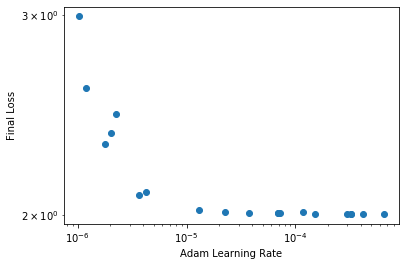

Train on 8906 samples, validate on 2227 samples
Epoch 1/18
8906/8906 [==============================] - 2s 237us/sample - loss: 30.2369 - output_1_loss: 0.2055 - output_2_loss: 0.0917 - output_3_loss: 0.5655 - output_4_loss: 28.0984 - val_loss: 5.5444 - val_output_1_loss: 0.2641 - val_output_2_loss: 0.0848 - val_output_3_loss: 0.3546 - val_output_4_loss: 4.2750
Epoch 2/18
8906/8906 [==============================] - 1s 67us/sample - loss: 2.7190 - output_1_loss: 0.1847 - output_2_loss: 0.0645 - output_3_loss: 0.2432 - output_4_loss: 1.8105 - val_loss: 2.4332 - val_output_1_loss: 0.1622 - val_output_2_loss: 0.0583 - val_output_3_loss: 0.1802 - val_output_4_loss: 1.7501
Epoch 3/18
8906/8906 [==============================] - 1s 65us/sample - loss: 1.6886 - output_1_loss: 0.1477 - output_2_loss: 0.0482 - output_3_loss: 0.1291 - output_4_loss: 1.1606 - val_loss: 1.3373 - val_output_1_loss: 0.0772 - val_output_2_loss: 0.0486 - val_output_3_loss: 0.0995 - val_output_4_loss: 0.9410
Epoch 4/18

In [7]:
## Step 4. Select the best model from the 20 autoencoder-only results

# List of learning rates and final losses, losses averaged over final 5 epochs
lrs = []
final_losses = []

for i in range(num_init_models):
    _, hist, lr, _ = models[i]
    final_losses.append(np.mean(hist.history['loss'][-5:]))
    lrs.append(lr)


# Select the best model, based on the minimum in the final losses
best_model_idc = np.argmin(final_losses)
best_model = models[best_model_idc][0]
best_lr = lrs[best_model_idc]

# Save weights for the best model
model_weight_path = "./data/{}_best_aec_model_weights.tf".format(expt_name)
best_model.save_weights(model_weight_path)


## Optional Step: Plot learning rates vs autoencoder-only losses
plt.figure()
plt.loglog(lrs, final_losses, 'o')
plt.ylabel("Final Loss")
plt.xlabel("Adam Learning Rate")
plt.show()



## Step 5. Set up the full architecture run!!

# Set up validation data, loss functions, and number of epochs
val_data = [(data_val_u, data_val_f), 
            (data_val_u, data_val_f, data_val_f, data_val_u)]
loss_fns = 4*[NMSE()]

# Compute number of epochs to fit full model
# about 1 epoch/sec in this step
final_epochs = int(final_model_train_hrs*60*60) # 1 epoch/sec

# Instantiate the new model
full_model = AbstractArchitecture(**architecture_config,
                                  train_autoencoders_only=False)

# Load the weights
full_model.load_weights(model_weight_path)
model.compile(loss=loss_fns, optimizer=optimizer(learning_rate=best_lr))

# Continue training the (now full) model
hist = model.fit(x=[data_train_u, data_train_f],
                 y=[data_train_u, data_train_f, data_train_f, data_train_u],
                 validation_data=val_data,
                 callbacks=cbs,
                 batch_size=batch_size,
                 epochs=full_epochs)

# And save the final results!
full_model_weights_path = "./data/{}_final_model_weights.tf".format(expt_name)
best_model.save_weights(full_model_weights_path)

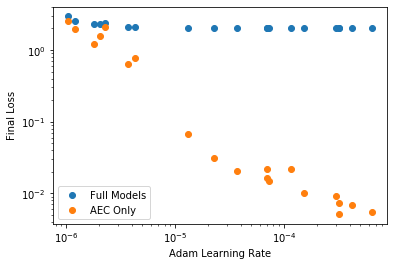

(0.005119411270067573, 2.0016387113242353)

In [12]:
lrs = []
full_losses = []
aec_losses = []
for i in range(num_init_models):
    _, hist, lr, aec_hist = models[i]
    full_losses.append(np.mean(hist.history['loss'][-3:]))
    aec_losses.append(np.mean(aec_hist.history['loss'][-3:]))
    lrs.append(lr)
    
## Optional Step: Plot learning rates vs autoencoder-only losses
plt.figure()
plt.loglog(lrs, full_losses, 'o', label="Full Models")
plt.loglog(lrs, aec_losses, 'o', label="AEC Only")
plt.ylabel("Final Loss")
plt.xlabel("Adam Learning Rate")
plt.legend()
plt.show()

min(aec_losses), min(full_losses)

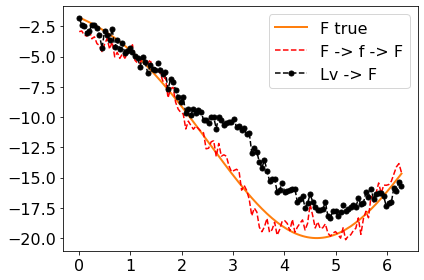

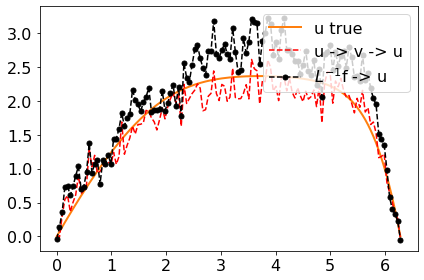

In [9]:
plot_model_prediction(model, 144, data_val_u, data_val_f)